# Analyse EUC transport in INALT20 and observation along 23$^{\circ}$W

For both, model and observations we calculate the central position $ Y_{CM} $ and along-pathway intensity $ INT $ of zonal currents using the algorithm of Hsin (2012). 

\begin{equation}
Y_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} y\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Y_CM}
\end{equation}

\begin{equation}
INT(x,t) = \int_{Z_l}^{Z_u} \int_{Y_{CM}-W}^{Y_{CM}+W} u(x,y,z,t)\ dy\ dz 
\label{equ_INT}
\end{equation}


where $y$ is latitude, $x$ is longitude, $u$ is zonal velocity, $z$ is depth, $t$ is time, $Z_u$ ($Z_l$) is upper (lower) boundary of the flow, $Y_N$ ($Y_S$) is northern (southern) limit of the flow, and $W$ is the half mean width of the flow.

![](../figures/INALT20_obs_23w_comparison/1_INALT20_obs_23w_1999_2012.png)

For transport calculation of the EUC Brandt et al. (2014) used the following boundary conditions:

$Z_u = 30\,$m, $Z_l = 300\,$m, $Y_N = 1.2^{\circ}$N, $Y_S = 1.2^{\circ}$S

To be consistent with the mooring reconstructed transport of Brandt et al (2014), I will first use $Y_N = 1.2^{\circ}$N, $Y_S = 1.2^{\circ}$S as meridional boundaries for the transport calculations. That will be compared to calculations with a variable meridional boundary. Based on the 23$^{\circ}$W section, I choose $W = 2^{\circ}$.

The depth of the EUC core $Z_{CM}$ will be estimated similar to $Y_{CM}$:

\begin{equation}
Z_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} z\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Z_CM}
\end{equation}

Think about variable depth boundaries. Or boundaries define by density. Because is the model we calculate the EUC transport along the equator, not only at 23W.

- [ ] literature review about depth of EUC in western and eastern basin.


## Tech preample

In [1]:
%matplotlib inline
import os
import dask
import cmocean
import datetime
import nc_time_axis
import cftime
import gsw
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from pathlib import Path
from scipy.io import loadmat
from IPython.display import Markdown as md
import xscale.signal.fitting as xfit
import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(
#     # Dask worker size
#     cores=4, memory='24GB',
#     processes=1, # Dask workers per job
#     # SLURM job script things
#     queue='cluster', walltime='01:30:00',
#     # Dask worker network and temporary storage
#     interface='ib0', local_directory='$TMPDIR',
#     log_directory='./slurm-logs'
# )

In [3]:
from dask.distributed import Client

In [4]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41917 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:39921' processes=1 threads=8, memory=12.00 GB>

In [5]:
# cluster.adapt(
#     minimum=1, maximum=20
# )

## Output parameters

In [6]:
out_dir_fig = Path('../figures/INALT20_obs_EUC_transport_23W/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_fig_1 = 'INALT_JRA_CORE_obs_EUC_transp_23W'
out_fig_2 = 'EUC_harmonic_fit_23W'
out_fig_3 = ''
fig_format = '.png'

savefig = 1; #set one if figures should be saved

## Input parameters
For Observations: mean section along 23$^{\circ}$W from Brandt et al 2015

In [7]:
global_data_path_obs2 = Path('../data/')
file_name_obs2 = '23W_ship_section/Burmeister_et_al_2020/ship_sections_23w_merged_all_mean.mat'
file_name_moor = '23W_0_mooring_transports/euc_transport_2005_2019_upos_1.2NS_30_300m.mat'

For INALT20 

In [8]:
global_data_path = Path("../data/INALT20_EUC_calc_transport/")
JRA_path = ""
exp_id = "INALT20.L46-KFS10?"

CORE_path = ""
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

# restr_years1 = "200[8-9]"  # restricts to 2010 and 2011
# restr_years1 = "2010"

# chunk sizes
# chu_x = 101 # None means take the full dataset
# chu_y = 101
# chu_z = 23
# chu_t = 1


Calculation of EUC - Boundary conditions

In [9]:
Z_u = 30
Z_l = 300

Y_N = 1.2
Y_S = -1.2

Wy = 2 #degE, meridional half-width
Wz = 100 #m, depth half-"width"

lonlim = [-40, 10]
latlim = [-2.5, 2.5]
zlim = [0, 400]
tlim = ['1958-01-01','2019-12-31']

p_ref = 0 # dbar; reference pressure for potential density calculation

Find relevant data files for INALT20

In [10]:
JRA_files = list(sorted(
    (global_data_path / JRA_path ).glob(
        f"{nest_prefix}{exp_id}{temp_res}*.nc")
))

CORE_files = list(sorted(
    (global_data_path / CORE_path ).glob(
#         f"{nest_prefix}{CORE_exp_id}{temp_res}{restr_years1}????_{restr_years1}????_grid_U.nc"
        f"{nest_prefix}{CORE_exp_id}{temp_res}*.nc"
    )
))

print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")

Found 52 CORE files and 61 JRA files.


## Load model output

In [11]:
%%time
ds_JRA = xr.open_mfdataset(
    JRA_files,
    combine='by_coords',
    decode_cf=True
)

CPU times: user 608 ms, sys: 102 ms, total: 710 ms
Wall time: 5.81 s


In [12]:
%%time
ds_CORE = xr.open_mfdataset(
    CORE_files,
    combine='by_coords',
    decode_cf=True
)

CPU times: user 445 ms, sys: 64.1 ms, total: 509 ms
Wall time: 3.84 s


In [13]:
def jd2dt64ns(jd):
    #  function jd2dt64ns(jd)
    #  
    #  jd2dt64ns Convert Julian day to datetime64.
    #  jd2dt64ns(JD) converts decimal Julian days to datetime64
    #  dates using the astronomical convension, but with time zero starting
    #  at midnight instead of noon.  In this convention, Julian day 2440000
    #  begins at 0000 hours, May 23, 1968. A datetime64ns array
    #  is returned.
    # 
    # Kristin Burmeister, SAMS
    # adapted from Matlab routine "gregorian" by Christian Mertens, IfM Kiel 
    # version: GEOMAR SVN $Id: gregorian.m 178 2016-06-21 09:53:03Z gkrahmann@geomar.de $
    # $Revision: 178 $ $Date: 2016-06-21 10:53:03 +0100 (Tue, 21 Jun 2016) $
    # Matlab routine adapted from the FORTRAN routine `kdate' by L. Masannek, M. Hirschberg,
    # and J. Holtorff (1980)

    hh = jd%1*24;
    jd = np.fix(jd-2385859);
    yy = np.fix((4*jd - 1)/1461);
    dd = np.fix(4*jd - 1461*yy - 1);
    yy = np.fix(yy + 1820);
    dd = np.fix((dd + 4)/4);
    mm = np.fix((5*dd - 3)/153);
    dd = np.fix(5*dd - 153*mm - 3);
    dd = np.fix((dd + 5)/5);

    mm = mm + 3;
    yy[mm>12]+=1
    mm[mm>12]-=12

    date = np.column_stack((yy,mm,dd,hh,hh*0,hh*0)).astype(int)
    time_test = np.array([(datetime.datetime(y,m,d,h,mi,s))
                         for y,m,d,h,mi,s in date])
    return pd.to_datetime(time_test)

In [14]:
mooring = loadmat((global_data_path_obs2/file_name_moor))

mooring = loadmat((global_data_path_obs2/file_name_moor))
t_moor = jd2dt64ns(mooring['euc_time'].squeeze())

moor = xr.DataArray(mooring['euc_transport'].squeeze(),
                     coords=[('time',t_moor)],
                     dims=['time'])
moor.name = 'EUC transport'
moor.attrs['long_name'] = 'EUC transport'
moor.attrs['units']='Sv'

In [15]:
section = loadmat((global_data_path_obs2/file_name_obs2))

matlab_datenum = section['mt_sec'].squeeze().mean(0)
pd.to_datetime(matlab_datenum)
dt_time = np.empty(np.shape(matlab_datenum),np.dtype('datetime64[s]'))

for i,time in enumerate(matlab_datenum):
    dt_time[i]=datetime.date.fromordinal(int(matlab_datenum[i])) + datetime.timedelta(days=matlab_datenum[i]%1) - datetime.timedelta(days = 366)
dt_time = pd.to_datetime(dt_time)

u_array = xr.DataArray(section['u_array'],
                     coords=[('depth',section['depth_grid'].squeeze()),
                             ('lat',section['lat_grid'].squeeze()),
                             ('time',dt_time)],
                     dims=['depth','lat','time'])
u_array.name = 'u_array'
u_array.attrs['long_name'] = 'Zonal velocity'
u_array.attrs['units']='m/s'
u_array.lat.attrs['units']='degN'
u_array.lat.attrs['long_name']='Latitude'
u_array.depth.attrs['units']='m'
u_array.depth.attrs['long_name']='Depth'
v_array = xr.DataArray(section['v_array'],
                     coords=[('depth',section['depth_grid'].squeeze()),
                             ('lat',section['lat_grid'].squeeze()),
                             ('time',dt_time)],
                     dims=['depth','lat','time'])
v_array.name = 'v_array'
v_array.attrs['long_name'] = ('Meridioanl velocity')
v_array.attrs['units']='m/s'
t_array = xr.DataArray(section['t_insitu_array'],
                     coords=[('depth',section['depth_grid'].squeeze()),
                             ('lat',section['lat_grid'].squeeze()),
                             ('time',dt_time)],
                     dims=['depth','lat','time'])
t_array.name = 't_array'
t_array.attrs['long_name'] = ('Temperature')
t_array.attrs['units']='degC'
s_array = xr.DataArray(section['s_practical_array'],
                     coords=[('depth',section['depth_grid'].squeeze()),
                             ('lat',section['lat_grid'].squeeze()),
                             ('time',dt_time)],
                     dims=['depth','lat','time'])
s_array.name = 's_array'
s_array.attrs['long_name'] = ('Salinity')
s_array.attrs['units']='PSU'
o2_array = xr.DataArray(section['o_mumolkg_array'],
                     coords=[('depth',section['depth_grid'].squeeze()),
                             ('lat',section['lat_grid'].squeeze()),
                             ('time',dt_time)],
                     dims=['depth','lat','time'])
o2_array.name = 'o2_array'
o2_array.attrs['long_name'] = ('Dissolved oxygen')
o2_array.attrs['units']='mu_mol/kg'
gn_array = xr.DataArray(section['gn_array'],
                     coords=[('depth',section['depth_grid'].squeeze()),
                             ('lat',section['lat_grid'].squeeze()),
                             ('time',dt_time)],
                     dims=['depth','lat','time'])
gn_array.name = 'gn_array'
gn_array.attrs['long_name'] = ('Neutral density')
gn_array.attrs['units']='kg/m3'
obs_23W_2020 = xr.merge([u_array,v_array,t_array,s_array,o2_array,gn_array])

## 23 zonal velocity sections

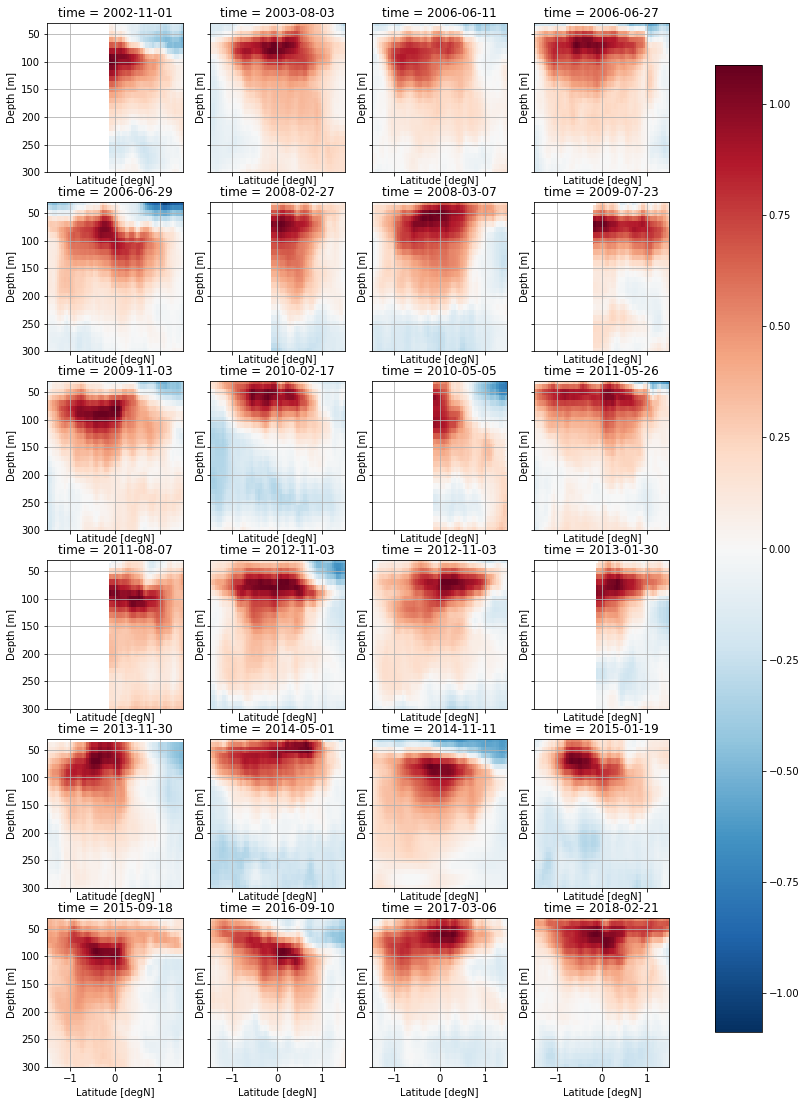

In [17]:
fig,axs = plt.subplots(6,4,figsize=[12.8, 19.2],sharex=True,sharey=True)

for i,ax in enumerate(axs.flat[0:24]):
    im = obs_23W_2020.isel(time=i).u_array.plot(ax=ax,x='lat',y='depth',
                                                yincrease=False,xlim=[-1.5,1.5],ylim=[300,30],
                                          add_colorbar=False)
    plt.tight_layout
    ax.grid()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Find sections which cover the entire EUC region

In [18]:
lat_min = obs_23W_2020.lat.where(obs_23W_2020.sel(depth=50,method='nearest').u_array.notnull())
obs_23W_2020 = obs_23W_2020.where(lat_min.min(dim='lat')<=Y_S,drop=True)

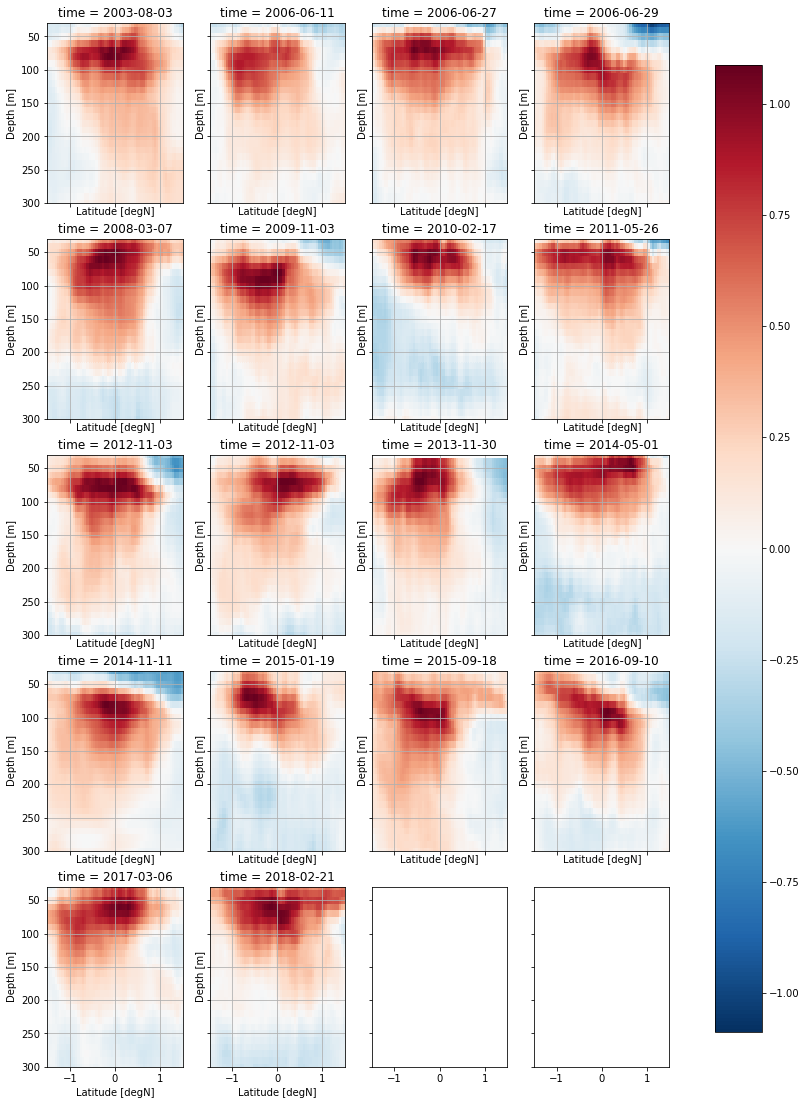

In [19]:
fig,axs = plt.subplots(5,4,figsize=[12.8, 19.2],sharex=True,sharey=True)

for i,ax in enumerate(axs.flat[0:18]):
    im = obs_23W_2020.isel(time=i).u_array.plot(ax=ax,x='lat',y='depth',
                                                yincrease=False,xlim=[-1.5,1.5],ylim=[300,30],
                                          add_colorbar=False)
    plt.tight_layout
    ax.grid()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

## EUC transport at 23W

In [20]:
def eastw_transport(ucur,dy,dz,z_dim,y_dim):
    ucur = ucur.where(ucur>=0)
    trs_e = 1e-6*(dy*(ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)
    trs_e.attrs['units']='Sv'
    trs_e.attrs['long_name']='Eastward transport'
    return trs_e

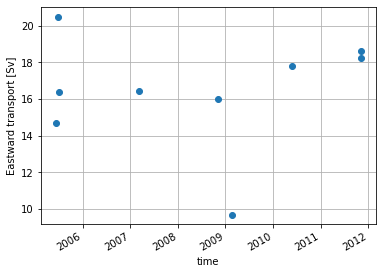

In [21]:
dy = gsw.distance([-23,-23],np.array(obs_23W_2020.lat[:2]))
dz = obs_23W_2020.depth[:2].diff(dim='depth')
ucur = obs_23W_2020.sel(depth=slice(Z_u,Z_l),lat=slice(Y_S,Y_N)).u_array
EUC_obs = eastw_transport(ucur,dy,dz.values,'depth','lat')
EUC_obs.sel(time=slice('2006','2012')).plot.line('o')
plt.grid()

In [22]:
ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice('1958','2009')).time_counter
ds_CORE

<xarray.Dataset>
Dimensions:       (lon: 799, time_counter: 3796)
Coordinates:
  * lon           (lon) float32 -39.92 -39.88 -39.83 ... -0.125 -0.075 -0.025
  * time_counter  (time_counter) datetime64[ns] 1958-01-03T12:00:00 ... 2009-...
Data variables:
    Y_CM          (lon, time_counter) float64 dask.array<chunksize=(799, 73), meta=np.ndarray>
    Z_CM          (lon, time_counter) float64 dask.array<chunksize=(799, 73), meta=np.ndarray>
    INT           (lon, time_counter) float64 dask.array<chunksize=(799, 73), meta=np.ndarray>
    T_30          (lon, time_counter) float64 dask.array<chunksize=(799, 73), meta=np.ndarray>
    T_0           (lon, time_counter) float64 dask.array<chunksize=(799, 73), meta=np.ndarray>
Attributes:
    title:      EUC transports in INALT20 CORE
    timeStamp:  2021-03-12 16:30:20.836844
    history:    Original model output modified using INALT20_EUC_calc_transpo...

In [23]:
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

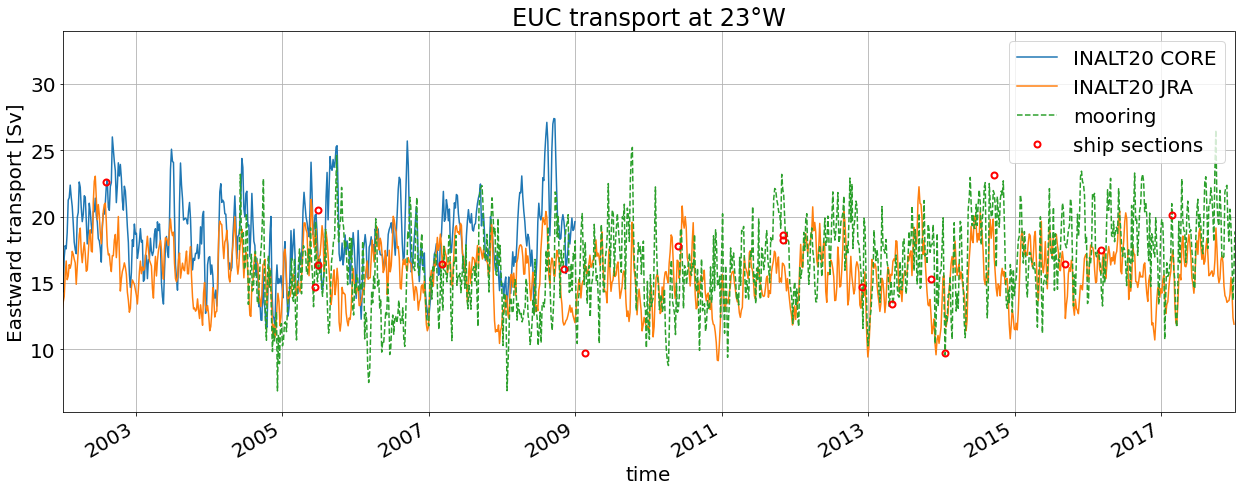

In [24]:
# fig = plt.figure(figsize=[12.8, 4.8])


ds_CORE.T_30.sel(lon=-23,method='nearest').plot.line(label='INALT20 CORE',aspect=3, size=7,xlim=['2003','2019'])
ds_JRA.T_30.sel(lon=-23,method='nearest').plot.line(label='INALT20 JRA')
moor.resample(time='5D').mean('time').plot.line('--',label='mooring')
EUC_obs.plot.line('or',label='ship sections',markerfacecolor='None',markeredgewidth=2)

plt.legend()
plt.grid()
# plt.rc('font', **font)
plt.tight_layout
plt.title('EUC transport at 23°W')

if savefig:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_1}{fig_format}"),dpi=300)

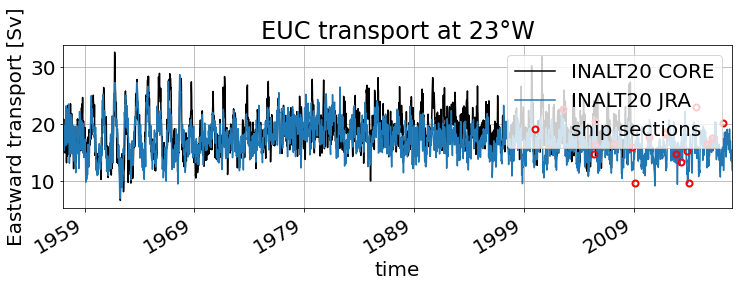

In [25]:
ds_CORE.T_30.sel(lon=-23,method='nearest').plot.line('k',label='INALT20 CORE',aspect=4, size=3,xlim=['1958','2019'])
ds_JRA.T_30.sel(lon=-23,method='nearest').plot.line(label='INALT20 JRA')
EUC_obs.plot.line('or',label='ship sections',markerfacecolor='None',markeredgewidth=2)
plt.legend()
plt.grid()
plt.tight_layout
plt.title('EUC transport at 23°W')

if 0:
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_1}{fig_format}"),dpi=300)

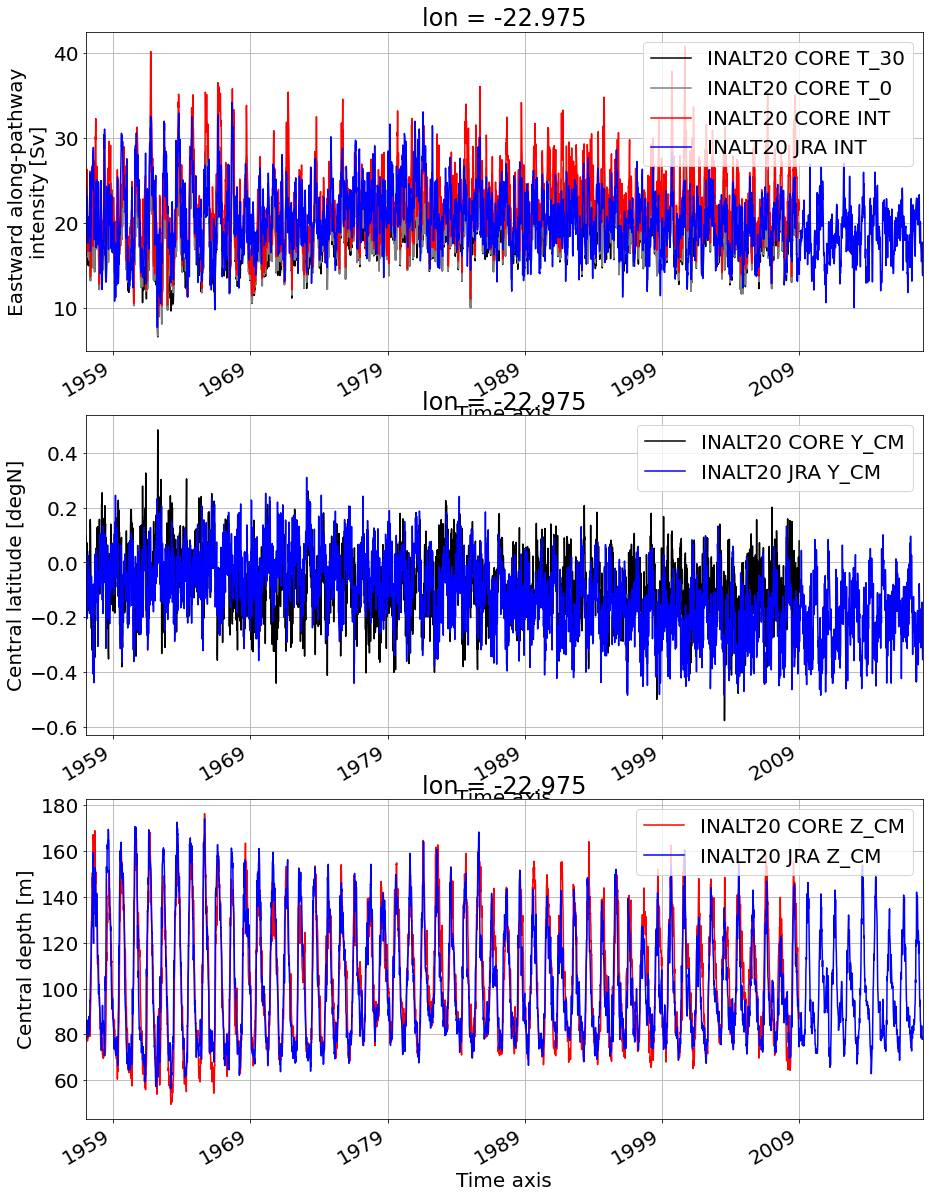

In [26]:
fig,axs = plt.subplots(3,1,figsize=[15,20])
ds_CORE.T_30.sel(lon=-23,method='nearest').plot.line('k',ax=axs[0],label='INALT20 CORE T_30',xlim=['1958','2019'])
ds_CORE.T_0.sel(lon=-23,method='nearest').plot.line(color='grey',ax=axs[0],label='INALT20 CORE T_0')
ds_CORE.INT.sel(lon=-23,method='nearest').plot.line('r',ax=axs[0],label='INALT20 CORE INT')
ds_JRA.INT.sel(lon=-23,method='nearest').plot.line('b',ax=axs[0],label='INALT20 JRA INT')
# axs[0].set_title('EUC transport at 23°W')

ds_CORE.Y_CM.sel(lon=-23,method='nearest').plot.line('k',ax=axs[1],label='INALT20 CORE Y_CM',xlim=['1958','2019'])
ds_JRA.Y_CM.sel(lon=-23,method='nearest').plot.line('b',ax=axs[1],label='INALT20 JRA Y_CM')
# axs[1].set_title('EUC central position at 23°W')

ds_CORE.Z_CM.sel(lon=-23,method='nearest').plot.line('r',ax=axs[2],label='INALT20 CORE Z_CM',xlim=['1958','2019'])
ds_JRA.Z_CM.sel(lon=-23,method='nearest').plot.line('b',ax=axs[2],label='INALT20 JRA Z_CM')
# axs[2].set_title('EUC core depth at 23°W')

for idx,ax in enumerate(axs.flat):
    ax.legend()
    ax.grid()

# plt.tight_layout

### power spectrum

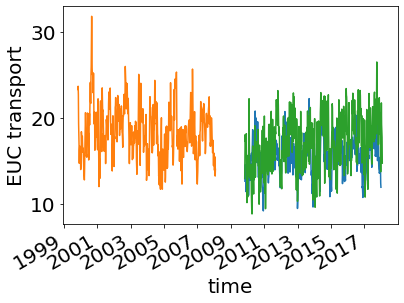

In [106]:
# select same timeseries length
x_JRA = ds_JRA.T_30.sel(time_counter=slice('2010-11','2019-01')).sel(lon=-23,method='nearest')
x_CORE = ds_CORE.T_30.sel(time_counter=slice('2000-11','2009-01')).sel(lon=-23,method='nearest')
x_JRA_l = ds_JRA.T_30.sel(time_counter=slice('1958','2009')).sel(lon=-23,method='nearest')
x_CORE_l = ds_CORE.T_30.sel(time_counter=slice('1958','2009')).sel(lon=-23,method='nearest')
x_moor = moor.sel(time=slice('2010-11','2019-01')).resample(time='5D').mean()

x_JRA.plot(label='JRA')
x_CORE.plot(label='CORE')
x_moor.plot(label='MOOR')

In [107]:
nfft = np.array(ds_JRA.time_counter.shape)
dt = 5
df = 1/(nfft*dt);
f_nyq = 1/(2*dt);

JRA_time_spectrum = xfft.fft(x_JRA, dim='time_counter', dx=5., detrend='mean', tapering=True)
CORE_time_spectrum = xfft.fft(x_CORE, dim='time_counter', dx=5., detrend='mean', tapering=True)
JRA_time_spectrum_l = xfft.fft(x_JRA_l, dim='time_counter', dx=5., detrend='mean', tapering=True)
CORE_time_spectrum_l = xfft.fft(x_CORE_l, dim='time_counter', dx=5., detrend='mean', tapering=True)
moor_time_spectrum = xfft.fft(x_moor, dim='time', dx=5., detrend='mean', tapering=True)

In [108]:
JRA_time_ps = xfft.ps(JRA_time_spectrum)
CORE_time_ps = xfft.ps(CORE_time_spectrum)
JRA_time_ps_l = xfft.ps(JRA_time_spectrum_l)
CORE_time_ps_l = xfft.ps(CORE_time_spectrum_l)
moor_time_ps = xfft.ps(moor_time_spectrum)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:60: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', nonposx='clip')
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:93: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  twiny.set_xscale('log', nonposx='clip')


<function matplotlib.pyplot.tight_layout>

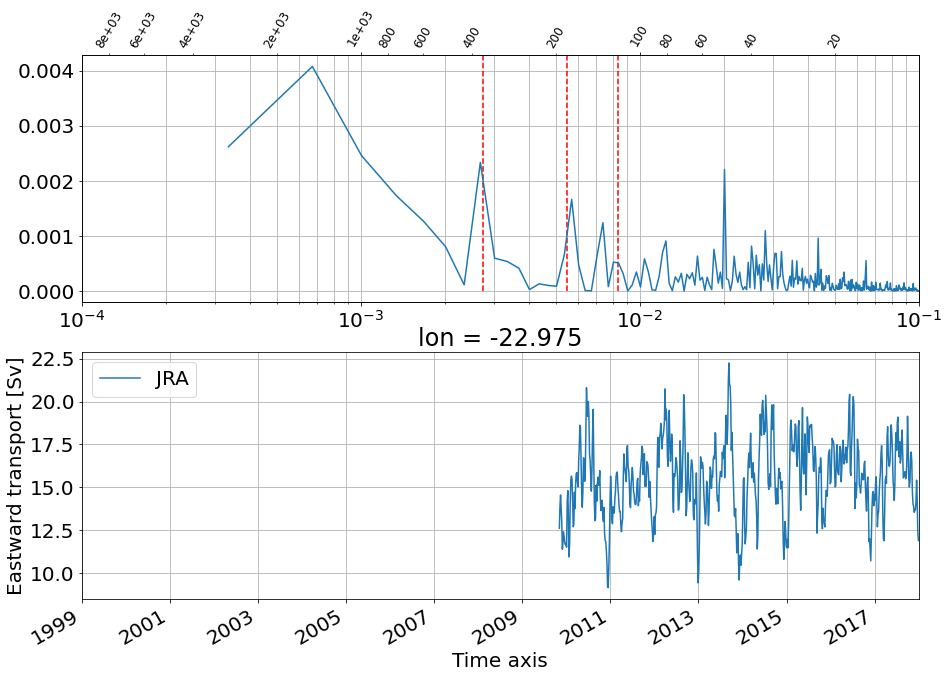

In [109]:
fig,axs = plt.subplots(2,1,figsize=[15,10])
plot_spectrum(JRA_time_ps, variance_preserving=True, ax=axs[0]);
axs[0].vlines([1/365, 1/182.5, 1/120],0,1,'r',linestyles='dashed')
x_JRA.plot(ax = axs[1],xlim=['2000','2019'],label='JRA')
axs[1].grid()
axs[1].legend()
plt.tight_layout

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:60: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', nonposx='clip')
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:93: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  twiny.set_xscale('log', nonposx='clip')


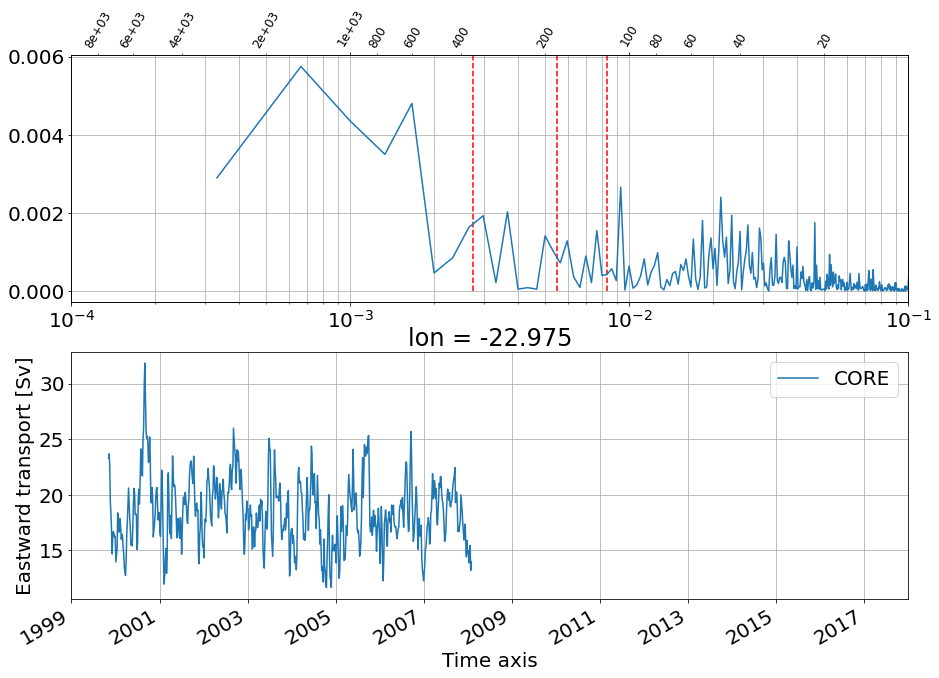

In [110]:
fig,axs = plt.subplots(2,1,figsize=[15,10])
plot_spectrum(CORE_time_ps, variance_preserving=True, ax=axs[0]);
axs[0].vlines([1/365, 1/182.5, 1/120],0,1,'r',linestyles='dashed')

x_CORE.plot(ax = axs[1],xlim=['2000','2019'],label='CORE')
axs[1].grid()
plt.tight_layout
axs[1].legend()

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:60: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', nonposx='clip')
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:93: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  twiny.set_xscale('log', nonposx='clip')


<function matplotlib.pyplot.tight_layout>

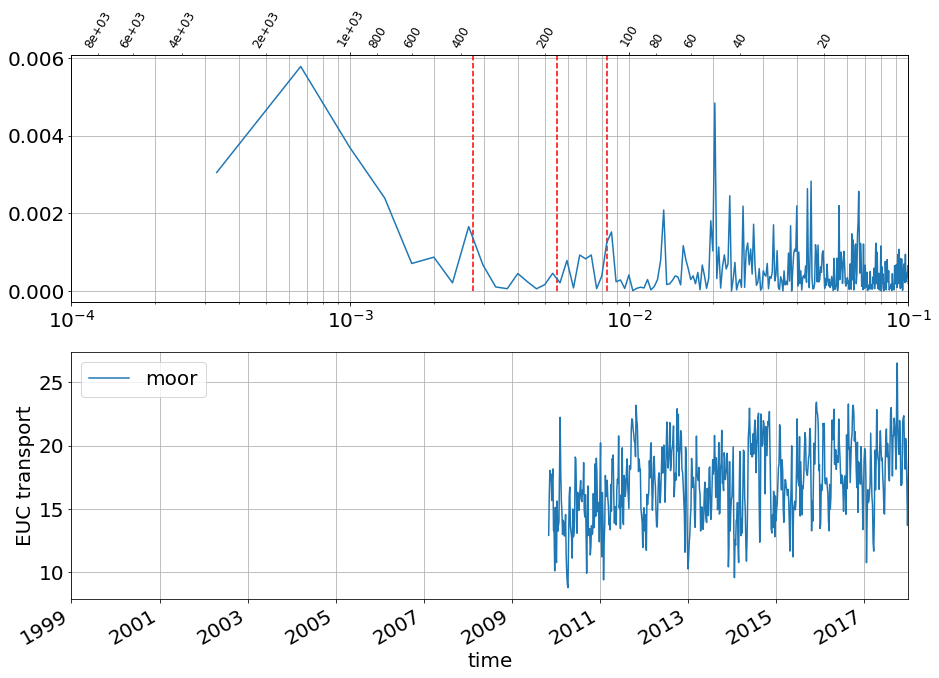

In [111]:
fig,axs = plt.subplots(2,1,figsize=[15,10])
plot_spectrum(moor_time_ps.sel(f_time=slice(1e-5,1e-1)), variance_preserving=True, ax=axs[0]);
axs[0].vlines([1/365, 1/182.5, 1/120],0,1,'r',linestyles='dashed')
x_moor.plot(ax = axs[1],xlim=['2000','2019'],label='moor')
axs[1].grid()
axs[1].legend()
plt.tight_layout

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:60: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', nonposx='clip')
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:93: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  twiny.set_xscale('log', nonposx='clip')
/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/xscale-0.1.dev0+35.ga804866-py3.7.egg/xscale/spectral/tools.py:60: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositiv

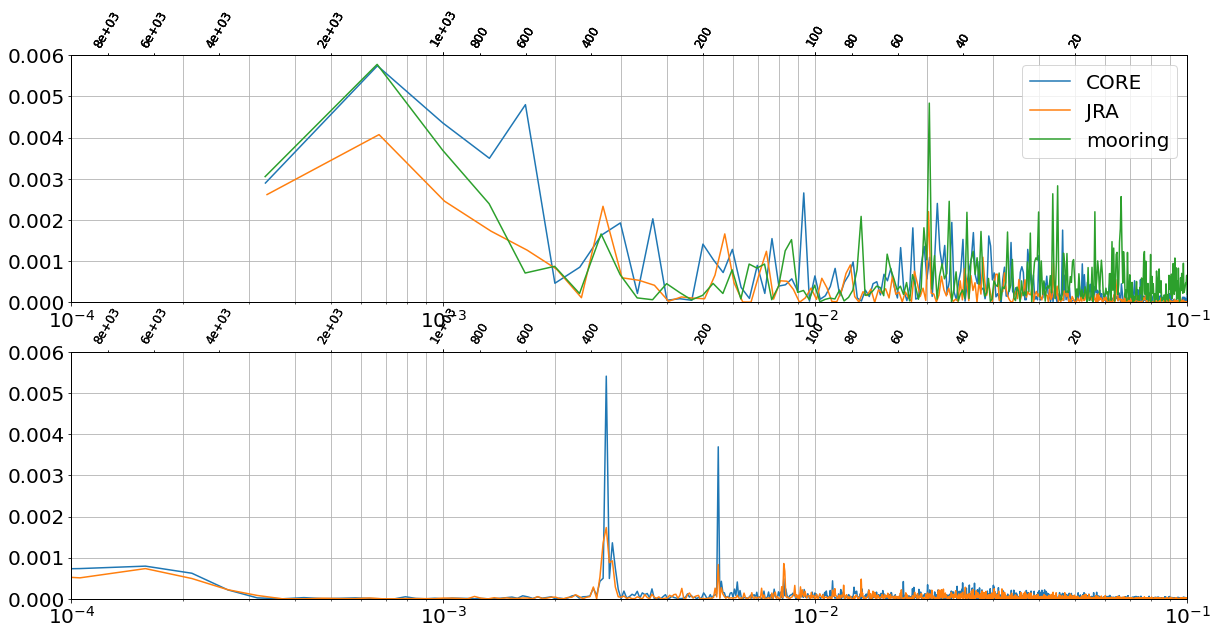

In [113]:
fig,axs = plt.subplots(2,1,figsize=[20,10])

plot_spectrum(CORE_time_ps, variance_preserving=True, ylim=[0,0.006], xlim=[1e-3,5e-2], ax=axs[0],label='CORE');
plot_spectrum(JRA_time_ps, variance_preserving=True, ylim=[0,0.006], xlim=[1e-3,5e-2], ax=axs[0],label='JRA');
plot_spectrum(moor_time_ps, variance_preserving=True, ylim=[0,0.006] , xlim=[1e-3,5e-2], ax=axs[0],label='mooring');

# axs[0].vlines([1/365, 1/182.5, 1/120],0,1,'k',linestyles='dashed')
axs[0].legend()

plot_spectrum(CORE_time_ps_l, variance_preserving=True, ylim=[0,0.006], xlim=[1e-3,5e-2], ax=axs[1],label='CORE');
plot_spectrum(JRA_time_ps_l, variance_preserving=True, ylim=[0,0.006], xlim=[1e-3,5e-2], ax=axs[1],label='JRA');

## Basin wide EUC
### EUC transport

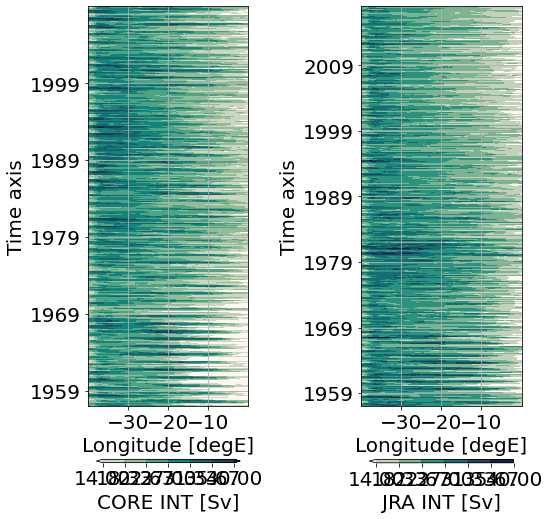

In [34]:
levs=7; cmin=14; cmax=40
fig,axs = plt.subplots(1,2,figsize=[8,8])
ds_CORE.INT.plot.contourf(ax=axs[0],x='lon',y='time_counter',cmap=cmocean.cm.tempo,
                          levels=levs, vmin=cmin, vmax=cmax,
                          cbar_kwargs={
                            "orientation": "horizontal",
                            "shrink": 0.9,
                            "aspect": 40,
                            "pad": 0.1,
                            'label':'CORE INT [Sv]'
                            },)
ds_JRA.INT.plot.contourf(ax=axs[1],x='lon',y='time_counter',cmap=cmocean.cm.tempo,
                          levels=levs, vmin=cmin, vmax=cmax,
                          cbar_kwargs={
                            "orientation": "horizontal",
                            "shrink": 0.9,
                            "aspect": 40,
                            "pad": 0.1,
                            'label':'JRA INT [Sv]'
                            },)

for ax in axs.flat:
    ax.grid('k')
plt.tight_layout()

### EUC core latitude

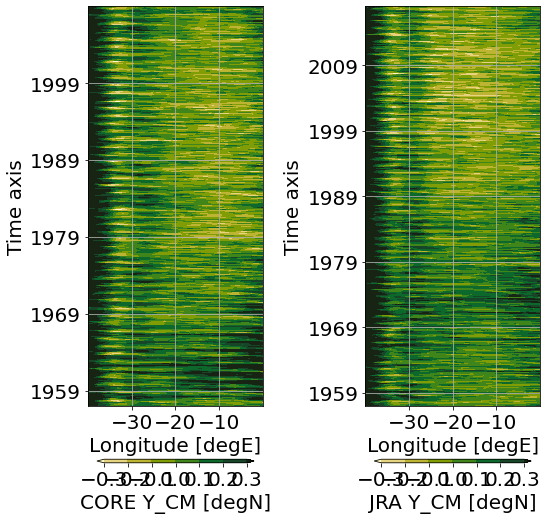

In [35]:
levs = 7; cmin = -0.3; cmax = 0.3

fig,axs = plt.subplots(1,2,figsize=[8,8])
ds_CORE.Y_CM.plot.contourf(ax=axs[0],x='lon',y='time_counter',cmap=cmocean.cm.speed,
                          levels=levs, vmin=cmin, vmax=cmax,
                          cbar_kwargs={
                            "orientation": "horizontal",
                            "shrink": 0.9,
                            "aspect": 40,
                            "pad": 0.1,
                            'label':'CORE Y_CM [degN]'
                            },)
ds_JRA.Y_CM.plot.contourf(ax=axs[1],x='lon',y='time_counter',cmap=cmocean.cm.speed,
                          levels=levs, vmin=cmin, vmax=cmax,
                          cbar_kwargs={
                            "orientation": "horizontal",
                            "shrink": 0.9,
                            "aspect": 40,
                            "pad": 0.1,
                            'label':'JRA Y_CM [degN]'
                            },)

for ax in axs.flat:
    ax.grid('k')
plt.tight_layout()

### EUC core depth

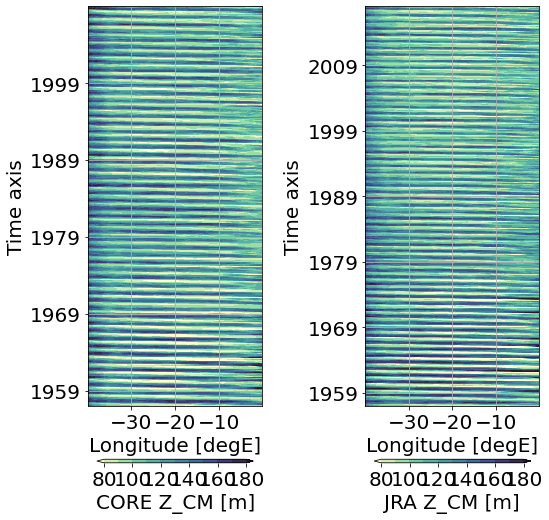

In [36]:
levs = 11; cmin = 80; cmax = 180

fig,axs = plt.subplots(1,2,figsize=[8,8])
ds_CORE.Z_CM.plot.contourf(ax=axs[0],x='lon',y='time_counter',cmap=cmocean.cm.deep,
                          levels=levs, vmin=cmin, vmax=cmax,
                          cbar_kwargs={
                            "orientation": "horizontal",
                            "shrink": 0.9,
                            "aspect": 40,
                            "pad": 0.1,
                            'label':'CORE Z_CM [m]'
                            },)
ds_JRA.Z_CM.plot.contourf(ax=axs[1],x='lon',y='time_counter',cmap=cmocean.cm.deep,
                          levels=levs, vmin=cmin, vmax=cmax,
                          cbar_kwargs={
                            "orientation": "horizontal",
                            "shrink": 0.9,
                            "aspect": 40,
                            "pad": 0.1,
                            'label':'JRA Z_CM [m]'
                            },)

for ax in axs.flat:
    ax.grid('k')
plt.tight_layout()

## Statistics

In [37]:
tlim_min, tlim_max = '1980','2009'
lolim_min,lolim_max = -35, -0

In [38]:
mean_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter','lon'])
std_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter','lon'])
mean_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter','lon'])
std_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter','lon'])

In [39]:
display(md('### CORE simulation'))
display(md('For the period 1980 to 2009, the EUC in CORE has a mean intensity of %5.2f $\pm$ %5.2f Sv (T$_{30}$=%5.2f $\pm$ %5.2f Sv, T$_{0}$=%5.2f $\pm$ %5.2f Sv).' %(
    mean_CORE.INT, std_CORE.INT,mean_CORE.T_30,std_CORE.T_30,mean_CORE.T_0,std_CORE.T_0)))
display(md('On average its core is located at %5.2f $\pm$ %5.2f$^{\circ}$N latitude and %5.2f $\pm$ %5.2fm depth.' %(
    mean_CORE.Y_CM, std_CORE.Y_CM,mean_CORE.Z_CM, std_CORE.Z_CM,)))

### CORE simulation

For the period 1980 to 2009, the EUC in CORE has a mean intensity of 20.73 $\pm$  5.63 Sv (T$_{30}$=17.36 $\pm$  4.13 Sv, T$_{0}$=17.90 $\pm$  4.43 Sv).

On average its core is located at -0.09 $\pm$  0.18$^{\circ}$N latitude and 105.12 $\pm$ 23.02m depth.

In [40]:
display(md('### JRA simulation'))
display(md('For the period 1980 to 2009, the EUC in JRA has a mean intensity of %5.2f $\pm$ %5.2f Sv (T$_{30}$=%5.2f $\pm$ %5.2f Sv, T$_{0}$=%5.2f $\pm$ %5.2f Sv).' %(
    mean_JRA.INT, std_JRA.INT,mean_JRA.T_30,std_JRA.T_30,mean_JRA.T_0,std_JRA.T_0)))
display(md('On average its core is located at %5.2f $\pm$ %5.2f$^{\circ}$N latitude and %5.2f $\pm$ %5.2fm depth.' %(
    mean_JRA.Y_CM, std_JRA.Y_CM,mean_JRA.Z_CM, std_JRA.Z_CM,)))

### JRA simulation

For the period 1980 to 2009, the EUC in JRA has a mean intensity of 18.86 $\pm$  4.52 Sv (T$_{30}$=15.90 $\pm$  3.46 Sv, T$_{0}$=16.46 $\pm$  3.71 Sv).

On average its core is located at -0.09 $\pm$  0.17$^{\circ}$N latitude and 102.21 $\pm$ 20.50m depth.

### EUC intensity JRA vs CORE

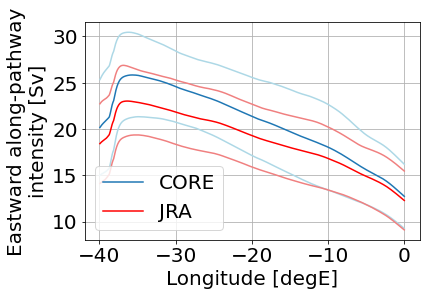

In [41]:
with xr.set_options(keep_attrs=True):
    mean_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter'])
    std_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter'])

    mean_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter'])
    std_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter'])
    
    mean_CORE.INT.coords['units'] = 'Sv'
    mean_CORE.INT.plot.line(x='lon',label='CORE')
    (mean_CORE.INT+std_CORE.INT).plot.line(x='lon',color='lightblue')
    (mean_CORE.INT-std_CORE.INT).plot.line(x='lon',color='lightblue')

    mean_JRA.INT.plot.line('r',x='lon',label='JRA')
    (mean_JRA.INT+std_JRA.INT).plot.line(x='lon',color='lightcoral')
    (mean_JRA.INT-std_JRA.INT).plot.line(x='lon',color='lightcoral')

    plt.legend()
    plt.grid()

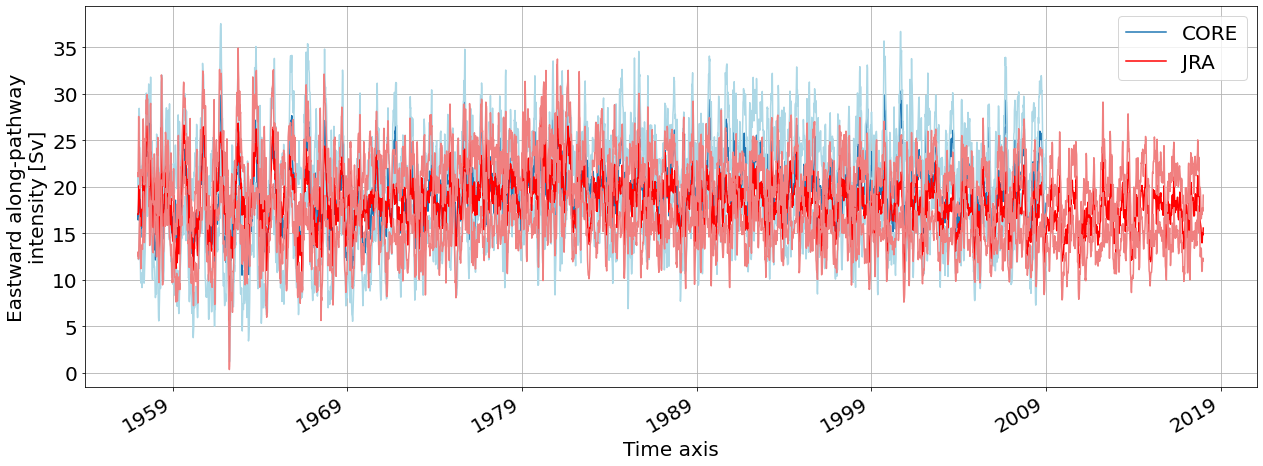

In [42]:
with xr.set_options(keep_attrs=True):
    mean_CORE = ds_CORE.sel(lon=slice(lolim_min,lolim_max)).mean(dim=['lon'])
    std_CORE = ds_CORE.sel(lon=slice(lolim_min,lolim_max)).std(dim=['lon'])

    mean_JRA = ds_JRA.sel(lon=slice(lolim_min,lolim_max)).mean(dim=['lon'])
    std_JRA = ds_JRA.sel(lon=slice(lolim_min,lolim_max)).std(dim=['lon'])
    
    mean_CORE.INT.coords['units'] = 'Sv'
    mean_CORE.INT.plot.line(x='time_counter',label='CORE',size=7,aspect=3)
    (mean_CORE.INT+std_CORE.INT).plot.line(x='time_counter',color='lightblue')
    (mean_CORE.INT-std_CORE.INT).plot.line(x='time_counter',color='lightblue')

    mean_JRA.INT.plot.line('r',x='time_counter',label='JRA')
    (mean_JRA.INT+std_JRA.INT).plot.line(x='time_counter',color='lightcoral')
    (mean_JRA.INT-std_JRA.INT).plot.line(x='time_counter',color='lightcoral')

    plt.legend()
    plt.grid()

### EUC core latitude JRA vs CORE

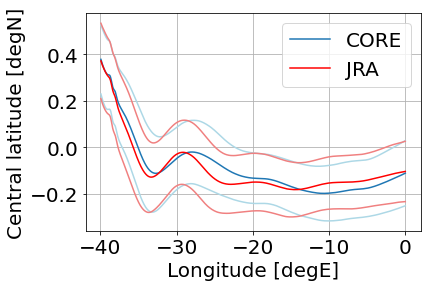

In [43]:
with xr.set_options(keep_attrs=True):
    mean_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter'])
    std_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter'])

    mean_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter'])
    std_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter'])
    
    mean_CORE.Y_CM.coords['units'] = 'Sv'
    mean_CORE.Y_CM.plot.line(x='lon',label='CORE')
    (mean_CORE.Y_CM+std_CORE.Y_CM).plot.line(x='lon',color='lightblue')
    (mean_CORE.Y_CM-std_CORE.Y_CM).plot.line(x='lon',color='lightblue')

    mean_JRA.Y_CM.plot.line('r',x='lon',label='JRA')
    (mean_JRA.Y_CM+std_JRA.Y_CM).plot.line(x='lon',color='lightcoral')
    (mean_JRA.Y_CM-std_JRA.Y_CM).plot.line(x='lon',color='lightcoral')

    plt.legend()
    plt.grid()

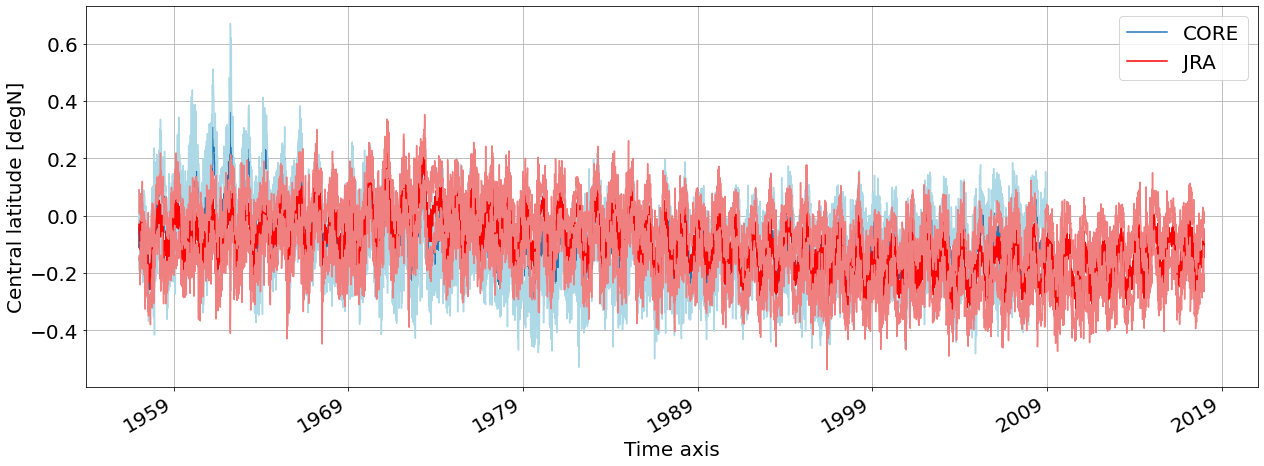

In [44]:
with xr.set_options(keep_attrs=True):
    mean_CORE = ds_CORE.sel(lon=slice(lolim_min,lolim_max)).mean(dim=['lon'])
    std_CORE = ds_CORE.sel(lon=slice(lolim_min,lolim_max)).std(dim=['lon'])

    mean_JRA = ds_JRA.sel(lon=slice(lolim_min,lolim_max)).mean(dim=['lon'])
    std_JRA = ds_JRA.sel(lon=slice(lolim_min,lolim_max)).std(dim=['lon'])
    
    mean_CORE.Y_CM.coords['units'] = 'Sv'
    mean_CORE.Y_CM.plot.line(x='time_counter',label='CORE',size=7,aspect=3)
    (mean_CORE.Y_CM+std_CORE.Y_CM).plot.line(x='time_counter',color='lightblue')
    (mean_CORE.Y_CM-std_CORE.Y_CM).plot.line(x='time_counter',color='lightblue')

    mean_JRA.Y_CM.plot.line('r',x='time_counter',label='JRA')
    (mean_JRA.Y_CM+std_JRA.Y_CM).plot.line(x='time_counter',color='lightcoral')
    (mean_JRA.Y_CM-std_JRA.Y_CM).plot.line(x='time_counter',color='lightcoral')

    plt.legend()
    plt.grid()

### EUC core depth JRA vs CORE

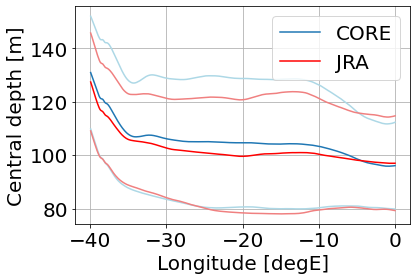

In [45]:
with xr.set_options(keep_attrs=True):
    mean_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter'])
    std_CORE = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter'])

    mean_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).mean(dim=['time_counter'])
    std_JRA = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).std(dim=['time_counter'])
    
    mean_CORE.Z_CM.coords['units'] = 'Sv'
    mean_CORE.Z_CM.plot.line(x='lon',label='CORE')
    (mean_CORE.Z_CM+std_CORE.Z_CM).plot.line(x='lon',color='lightblue')
    (mean_CORE.Z_CM-std_CORE.Z_CM).plot.line(x='lon',color='lightblue')

    mean_JRA.Z_CM.plot.line('r',x='lon',label='JRA')
    (mean_JRA.Z_CM+std_JRA.Z_CM).plot.line(x='lon',color='lightcoral')
    (mean_JRA.Z_CM-std_JRA.Z_CM).plot.line(x='lon',color='lightcoral')

    plt.legend()
    plt.grid()

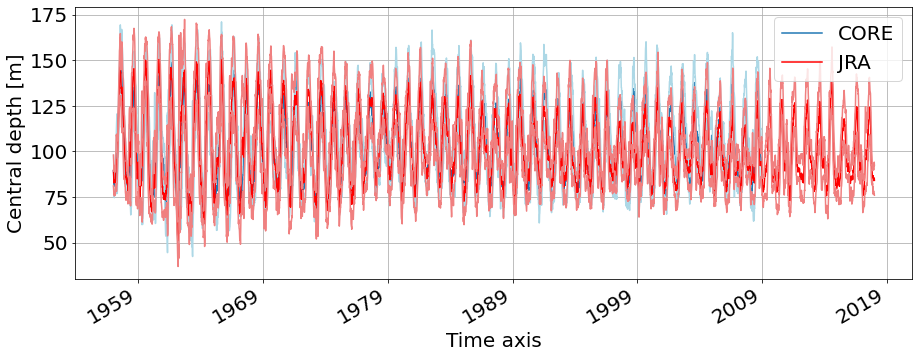

In [46]:
with xr.set_options(keep_attrs=True):
    mean_CORE = ds_CORE.sel(lon=slice(lolim_min,lolim_max)).mean(dim=['lon'])
    std_CORE = ds_CORE.sel(lon=slice(lolim_min,lolim_max)).std(dim=['lon'])

    mean_JRA = ds_JRA.sel(lon=slice(lolim_min,lolim_max)).mean(dim=['lon'])
    std_JRA = ds_JRA.sel(lon=slice(lolim_min,lolim_max)).std(dim=['lon'])
    
    mean_CORE.Z_CM.coords['units'] = 'Sv'
    mean_CORE.Z_CM.plot.line(x='time_counter',label='CORE',size=5,aspect=3)
    (mean_CORE.Z_CM+std_CORE.Z_CM).plot.line(x='time_counter',color='lightblue')
    (mean_CORE.Z_CM-std_CORE.Z_CM).plot.line(x='time_counter',color='lightblue')

    mean_JRA.Z_CM.plot.line('r',x='time_counter',label='JRA')
    (mean_JRA.Z_CM+std_JRA.Z_CM).plot.line(x='time_counter',color='lightcoral')
    (mean_JRA.Z_CM-std_JRA.Z_CM).plot.line(x='time_counter',color='lightcoral')

    plt.legend()
    plt.grid()

## Variability
- Annual cycle
- annual and semiannual harmonic?
- spectra
- apply filter?

## Climatology 1980-2009

In [47]:
tlim_min,tlim_max = '1980','2009'
with xr.set_options(keep_attrs=True):
    JRA_cyc = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim='time_counter')
    CORE_cyc = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim='time_counter')
JRA_cyc

<xarray.Dataset>
Dimensions:    (dayofyear: 73, lon: 799)
Coordinates:
  * lon        (lon) float32 -39.92 -39.88 -39.83 ... -0.125 -0.075 -0.025
  * dayofyear  (dayofyear) int64 3 8 13 18 23 28 33 ... 338 343 348 353 358 363
Data variables:
    Y_CM       (dayofyear, lon) float64 dask.array<chunksize=(1, 799), meta=np.ndarray>
    Z_CM       (dayofyear, lon) float64 dask.array<chunksize=(1, 799), meta=np.ndarray>
    INT        (dayofyear, lon) float64 dask.array<chunksize=(1, 799), meta=np.ndarray>
    T_30       (dayofyear, lon) float64 dask.array<chunksize=(1, 799), meta=np.ndarray>
    T_0        (dayofyear, lon) float64 dask.array<chunksize=(1, 799), meta=np.ndarray>
Attributes:
    title:      EUC transports in INALT20 JRA
    timeStamp:  2021-03-12 16:28:29.380776
    history:    Original model output modified using INALT20_EUC_calc_transpo...

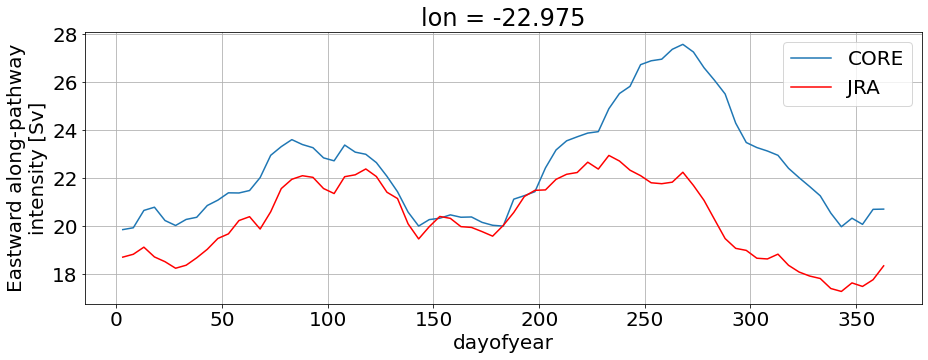

In [48]:
CORE_cyc.INT.sel(lon=-23,method='nearest').plot.line(label='CORE',size=5,aspect=3)
JRA_cyc.INT.sel(lon=-23,method='nearest').plot.line('r',label='JRA')
plt.grid()
plt.legend()

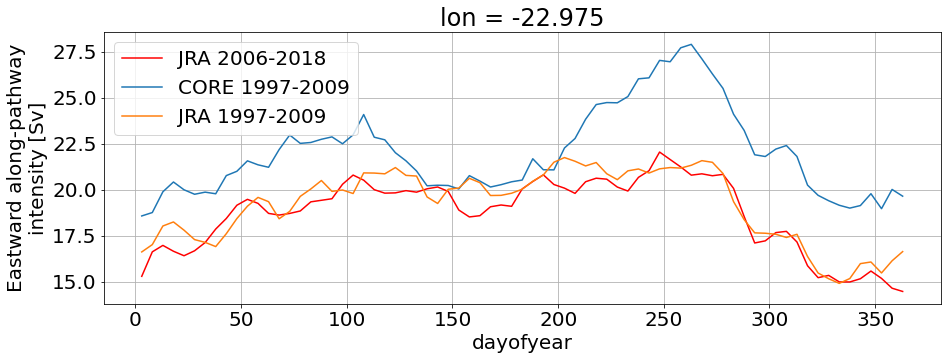

In [49]:
tlim_min,tlim_max = '2006','2018'
with xr.set_options(keep_attrs=True):
    JRA_cyc = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim='time_counter')
JRA_cyc.INT.sel(lon=-23,method='nearest').plot.line('r',label='JRA 2006-2018',size=5,aspect=3)

tlim_min,tlim_max = '1997','2009'
with xr.set_options(keep_attrs=True):
    JRA_cyc = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim='time_counter')
    CORE_cyc = ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim='time_counter')
CORE_cyc.INT.sel(lon=-23,method='nearest').plot.line(label='CORE 1997-2009')
JRA_cyc.INT.sel(lon=-23,method='nearest').plot.line(label='JRA 1997-2009')

plt.grid()
plt.legend()

### Annual and semiannual harmonics

In [50]:
JRA_fit2w = xfit.sinfit(ds_JRA.T_30.sel(time_counter=slice(tlim_min,tlim_max)),
                    dim='time_counter', periods=[182.5,365], unit='D')
CORE_fit2w = xfit.sinfit(ds_CORE.T_30.sel(time_counter=slice(tlim_min,tlim_max)),
                    dim='time_counter', periods=[182.5,365], unit='D')

reconstruct harmonic time series

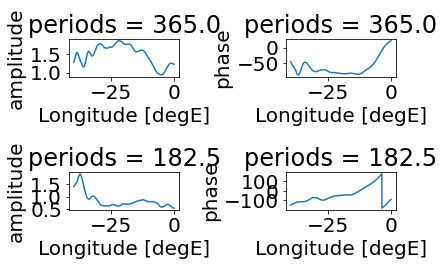

In [51]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
JRA_fit2w.sel(periods=365)['amplitude'].plot(ax=ax1)
JRA_fit2w.sel(periods=365)['phase'].plot(ax=ax2)
JRA_fit2w.sel(periods=182.5)['amplitude'].plot(ax=ax3)
JRA_fit2w.sel(periods=182.5)['phase'].plot(ax=ax4)
plt.tight_layout()
plt.show()

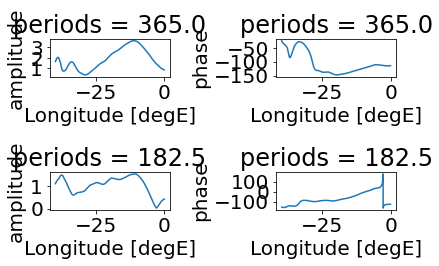

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
CORE_fit2w.sel(periods=365)['amplitude'].plot(ax=ax1)
CORE_fit2w.sel(periods=365)['phase'].plot(ax=ax2)
CORE_fit2w.sel(periods=182.5)['amplitude'].plot(ax=ax3)
CORE_fit2w.sel(periods=182.5)['phase'].plot(ax=ax4)
plt.tight_layout()
plt.show()

In [53]:
JRA_AH_SAH_fit = xfit.sinval(JRA_fit2w,
                             ds_JRA.time_counter.sel(
                                 time_counter=slice(tlim_min,tlim_max)))
JRA_SAH_fit = xfit.sinval(JRA_fit2w.sel(periods=[182.5,]), 
                         ds_JRA.time_counter.sel(
                                 time_counter=slice(tlim_min,tlim_max)))
JRA_AH_fit = xfit.sinval(JRA_fit2w.sel(periods=[365,]), 
                          ds_JRA.time_counter.sel(
                                 time_counter=slice(tlim_min,tlim_max)))

In [54]:
CORE_AH_SAH_fit = xfit.sinval(CORE_fit2w,
                             ds_CORE.time_counter.sel(
                                 time_counter=slice(tlim_min,tlim_max)))
CORE_SAH_fit = xfit.sinval(CORE_fit2w.sel(periods=[182.5,]), 
                         ds_CORE.time_counter.sel(
                                 time_counter=slice(tlim_min,tlim_max)))
CORE_AH_fit = xfit.sinval(CORE_fit2w.sel(periods=[365,]), 
                          ds_CORE.time_counter.sel(
                                 time_counter=slice(tlim_min,tlim_max)))

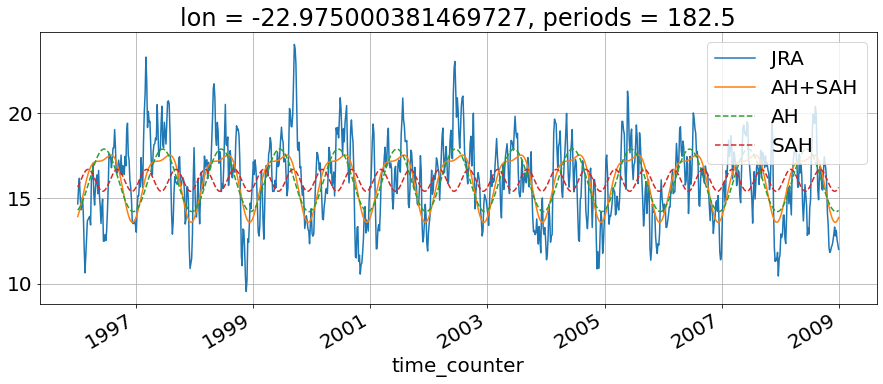

In [55]:
ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).T_30.sel(lon=-23,method='nearest').plot.line(label='JRA',size=5,aspect=3)
JRA_AH_SAH_fit.sel(lon=-23,method='nearest').plot.line(label='AH+SAH')
JRA_AH_fit.sel(lon=-23,method='nearest').plot.line(label='AH',
ls='--')
JRA_SAH_fit.sel(lon=-23,method='nearest').plot.line(label='SAH',
ls='--')
plt.grid()
plt.legend()
plt.show()

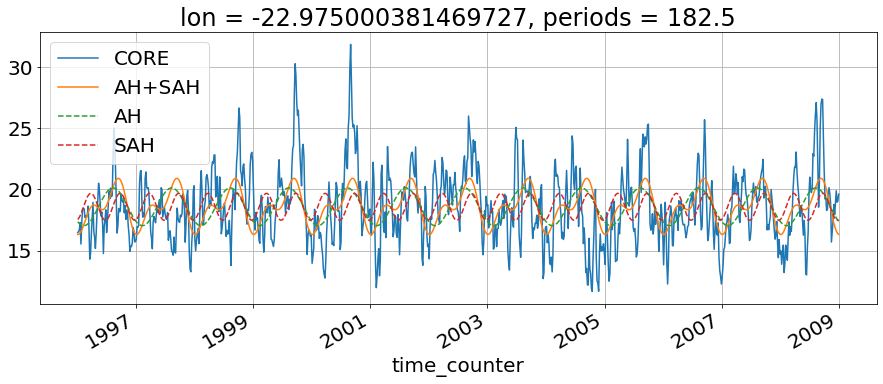

In [56]:
ds_CORE.sel(time_counter=slice(tlim_min,tlim_max)).T_30.sel(lon=-23,method='nearest').plot.line(label='CORE',size=5,aspect=3)
CORE_AH_SAH_fit.sel(lon=-23,method='nearest').plot.line(label='AH+SAH')
CORE_AH_fit.sel(lon=-23,method='nearest').plot.line(label='AH',
ls='--')
CORE_SAH_fit.sel(lon=-23,method='nearest').plot.line(label='SAH',
ls='--')
plt.grid()
plt.legend()
plt.show()

In [57]:
JRA_AH_SAH_CYC = xfit.sinval(JRA_fit2w, JRA_cyc.dayofyear)
JRA_SAH_CYC = xfit.sinval(JRA_fit2w.sel(periods=[182.5,]),JRA_cyc.dayofyear)
JRA_AH_CYC = xfit.sinval(JRA_fit2w.sel(periods=[365,]), JRA_cyc.dayofyear)

In [58]:
CORE_AH_SAH_CYC = xfit.sinval(CORE_fit2w, CORE_cyc.dayofyear)
CORE_SAH_CYC = xfit.sinval(CORE_fit2w.sel(periods=[182.5,]),CORE_cyc.dayofyear)
CORE_AH_CYC = xfit.sinval(CORE_fit2w.sel(periods=[365,]), CORE_cyc.dayofyear)

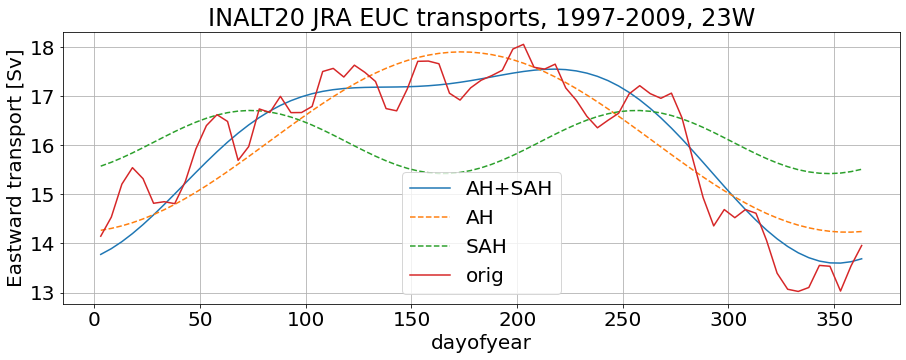

In [59]:
JRA_AH_SAH_CYC.sel(lon=-23,method='nearest').plot.line(label='AH+SAH',size=5,aspect=3)
JRA_AH_CYC.sel(lon=-23,method='nearest').plot.line(label='AH',
ls='--')
JRA_SAH_CYC.sel(lon=-23,method='nearest').plot.line(label='SAH',
ls='--')
JRA_cyc.T_30.sel(lon=-23,method='nearest').plot.line(label='orig')
plt.grid()
plt.legend()
plt.title(('INALT20 JRA EUC transports, '+tlim_min+'-'+tlim_max+', 23W'))
if savefig:
    plt.savefig((out_dir_fig / f"INALT_JRA_{out_fig_2}_mean{tlim_min}_{tlim_max}{fig_format}"),dpi=300)

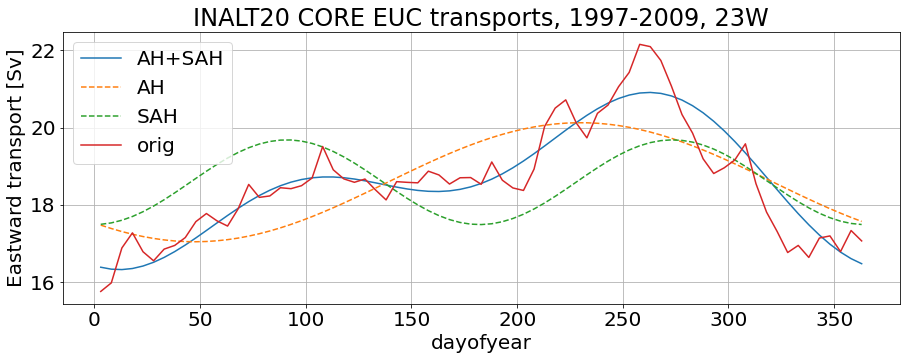

In [60]:
p=CORE_AH_SAH_CYC.sel(lon=-23,method='nearest').plot.line(label='AH+SAH',size=5,aspect=3)
CORE_AH_CYC.sel(lon=-23,method='nearest').plot.line(label='AH',
ls='--')
CORE_SAH_CYC.sel(lon=-23,method='nearest').plot.line(label='SAH',
ls='--')
CORE_cyc.T_30.sel(lon=-23,method='nearest').plot.line(label='orig')
plt.title(('INALT20 CORE EUC transports, '+tlim_min+'-'+tlim_max+', 23W'))
plt.grid()
plt.legend()
if savefig:
    plt.savefig((out_dir_fig / f"INALT_CORE_{out_fig_2}_mean{tlim_min}_{tlim_max}{fig_format}"),dpi=300)

## Climatology 2005-2019

In [61]:
tlim_min,tlim_max = '2006','2018'
test = moor.resample(time='5D').mean('time')
with xr.set_options(keep_attrs=True):
    JRA_cyc = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim='time_counter')
    CORE_cyc = ds_CORE.sel(time_counter=slice('1997','2009')).groupby('time_counter.dayofyear').mean(dim='time_counter')
    moor_cyc = moor.sel(time=slice(tlim_min,tlim_max)).groupby('time.dayofyear').mean(dim='time')

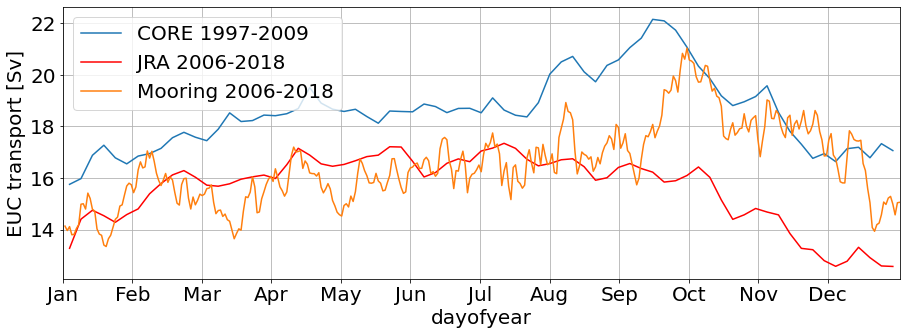

In [62]:
CORE_cyc.T_30.sel(lon=-23,method='nearest').plot.line(label='CORE 1997-2009',size=5,aspect=3)
JRA_cyc.T_30.sel(lon=-23,method='nearest').plot.line('r',label=f"JRA {tlim_min}-{tlim_max}")
moor_cyc.plot.line(label=f"Mooring {tlim_min}-{tlim_max}")
plt.grid()
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))

if savefig:
    plt.savefig((out_dir_fig / f"INALT_JRA_CORE_obs_cyc{tlim_min}_{tlim_max}{fig_format}"),dpi=300)

### harmonic fit

In [63]:
time = np.arange(moor.time[0].values, '2019-10-11', dtype='datetime64[D]')
np.size(time)

5246

In [64]:
moor.coords['time'] = time
moor

<xarray.DataArray 'EUC transport' (time: 5246)>
array([18.5649168 , 18.11159748, 17.07677014, ..., 16.26795072,
       15.41265752, 15.14468125])
Coordinates:
  * time     (time) datetime64[ns] 2005-05-31 2005-06-01 ... 2019-10-10
Attributes:
    long_name:  EUC transport
    units:      Sv

In [65]:
def sinfit_kb(array, periods, dim=None, coord=None, unit='s'):
    #     """
    #     Least squares sinusoidal fit.
    #     Fit sinusoidal functions ``y = A[p] * sin(2 * pi * ax * f[1] + phi[1])``
    #     Parameters
    #     ----------
    #     array : xarray.DataArray
    #         Data to be fitted
    #     periods: float or list of float
    #         The periods of the sinusoidal functions to be fitted
    #     dim : str, optional
    #         The dimension along which the data will be fitted. If not precised,
    #         the first dimension will be used
    #     unit : {'D', 'h', 'm', 's', 'ms', 'us', 'ns'}, optional
    #         If the fit uses a datetime dimension, the unit of the period may be
    #         specified here.
    #     Returns
    #     -------
    #     modes : Dataset
    #     A Dataset with the amplitude and the phase for each periods
    #     """
    import dask.array as da
    # if dim is None:
    dim = array.dims[0]
    # if _utils.is_scalar(periods):
    #     periods = [periods, ]
    n = 2 * len(periods) + 1
    # # Sort frequencies in ascending order
    periods.sort(reverse=True)
    # # Re-order the array to place the fitting dimension as the first dimension
    # # + stack the other dimensions
    array_stacked = array
    # dim_chunk = array.chunks[array.get_axis_num(dim)][0]
    # # Check if the dimension is associated with a numpy.datetime
    # # and normalize to use periods and time in seconds
    # if coord is None:
    coord = array[dim]
    t = coord.data.astype('f8') * 1e-9
    freqs = 1. / pd.to_timedelta(periods, unit=unit).total_seconds()
    # if _utils.is_datetime(coord):
    #     # Use the 1e-9 to scale nanoseconds to seconds (by default, xarray use
    #     # datetime in nanoseconds
    #     t = coord.data.astype('f8') * 1e-9
    #     freqs = 1. / pd.to_timedelta(periods, unit=unit).total_seconds()
    # else:
    #     t = coord.data
    #     freqs = 1. / periods
    # # Build coefficient matrix for the fit using the exponential form
    x = da.vstack([da.cos(2 * np.pi * f * t) for f in reversed(freqs)] +
                  [da.ones(len(t), chunks=73), ] +
                  [da.sin(2 * np.pi * f * t) for f in freqs]).T
    x = x.rechunk((73, n))
    # # Solve the least-square system
    c, _, _, _ = da.linalg.lstsq(x, array_stacked.data)
    # Get cosine (a) and sine (b) ampitudes
    b = c[0:n//2, ][::-1]
    a = c[n//2 + 1:, ]
    # # Compute amplitude and phase
    amplitude = da.sqrt(a ** 2 + b ** 2)
    phase = da.arctan2(b, a) * 180. / np.pi
    # Store the results
    new_dims = ('periods',) + array_stacked.dims[1:]
    new_coords = {co: array_stacked.coords[co] for co in array_stacked.coords
                  if co != dim}
    var_dict = {'amplitude': (new_dims, amplitude),
                'phase': (new_dims, phase),
                'offset': (array_stacked.dims[1:], c[n//2, ])}
    ds = xr.Dataset(var_dict, coords=new_coords)
    ds = ds.assign_coords(periods=periods)
    ds['periods'].attrs['units'] = unit
    # Unstack the data
    modes = ds
    return modes

In [66]:
JRA_fit2w = xfit.sinfit(ds_JRA.T_30.sel(time_counter=slice(tlim_min,tlim_max)),
                    dim='time_counter', periods=[182.5,365], unit='D')
CORE_fit2w = xfit.sinfit(ds_CORE.T_30.sel(time_counter=slice('1997','2009')),
                    dim='time_counter', periods=[182.5,365], unit='D')
moor_fit2w = sinfit_kb(moor.sel(time=slice(tlim_min,tlim_max)), periods=[182.5,365], unit='D')

In [67]:
JRA_AH_SAH_CYC = xfit.sinval(JRA_fit2w, JRA_cyc.dayofyear)
JRA_SAH_CYC = xfit.sinval(JRA_fit2w.sel(periods=[182.5,]),JRA_cyc.dayofyear)
JRA_AH_CYC = xfit.sinval(JRA_fit2w.sel(periods=[365,]), JRA_cyc.dayofyear)
JRA_SAH_CYC.attrs = moor.attrs;JRA_AH_SAH_CYC.attrs = moor.attrs;JRA_AH_CYC.attrs = moor.attrs

In [68]:
moor_AH_SAH_CYC = xfit.sinval(moor_fit2w, moor_cyc.dayofyear)
moor_SAH_CYC = xfit.sinval(moor_fit2w.sel(periods=[182.5,]),moor_cyc.dayofyear)
moor_AH_CYC = xfit.sinval(moor_fit2w.sel(periods=[365,]), moor_cyc.dayofyear)

In [69]:
CORE_AH_SAH_CYC = xfit.sinval(CORE_fit2w, CORE_cyc.dayofyear)
CORE_SAH_CYC = xfit.sinval(CORE_fit2w.sel(periods=[182.5,]),CORE_cyc.dayofyear)
CORE_AH_CYC = xfit.sinval(CORE_fit2w.sel(periods=[365,]), CORE_cyc.dayofyear)

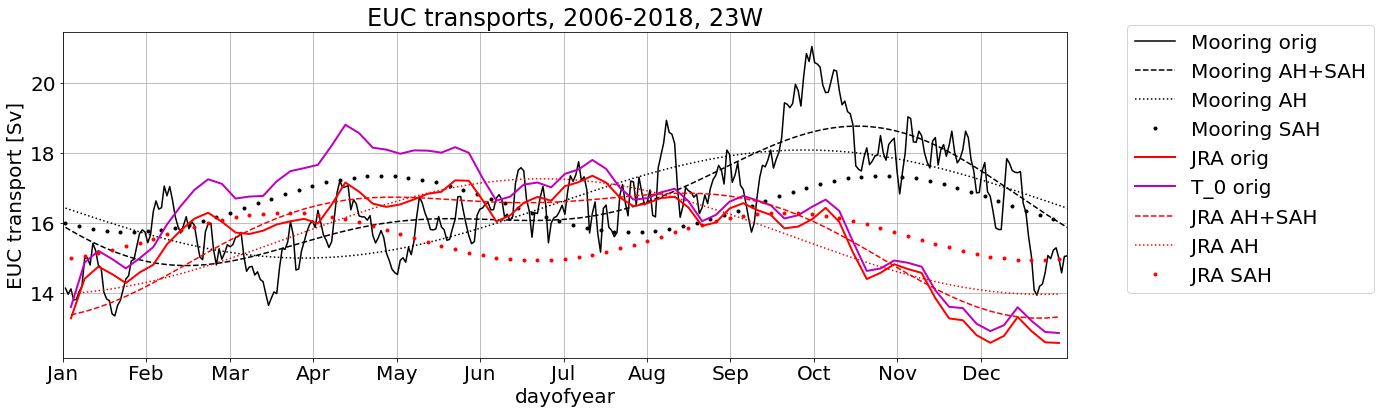

In [70]:
p=moor_cyc.plot.line('k',label='Mooring orig',size=6,aspect=3)
moor_AH_SAH_CYC.plot.line('--k',label='Mooring AH+SAH')
moor_AH_CYC.plot.line(':k',label='Mooring AH')
moor_SAH_CYC[0:-1:5].plot.line('.k',label='Mooring SAH')

JRA_cyc.T_30.sel(lon=-23,method='nearest').plot.line('r',label='JRA orig',linewidth=2)
JRA_cyc.T_0.sel(lon=-23,method='nearest').plot.line('m',label='T_0 orig',linewidth=2)
JRA_AH_SAH_CYC.sel(lon=-23,method='nearest').plot.line('--r',label='JRA AH+SAH')
JRA_AH_CYC.sel(lon=-23,method='nearest').plot.line(':r',label='JRA AH')
JRA_SAH_CYC.sel(lon=-23,method='nearest').plot.line('.r',label='JRA SAH')

plt.title(('EUC transports, '+tlim_min+'-'+tlim_max+', 23W'))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 0.85, 0.3, 0.2), loc='upper left')

plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))

if savefig:
    plt.savefig((out_dir_fig / f"INALT_JRA_obs_harmonics_cyc{tlim_min}_{tlim_max}{fig_format}"),dpi=300)

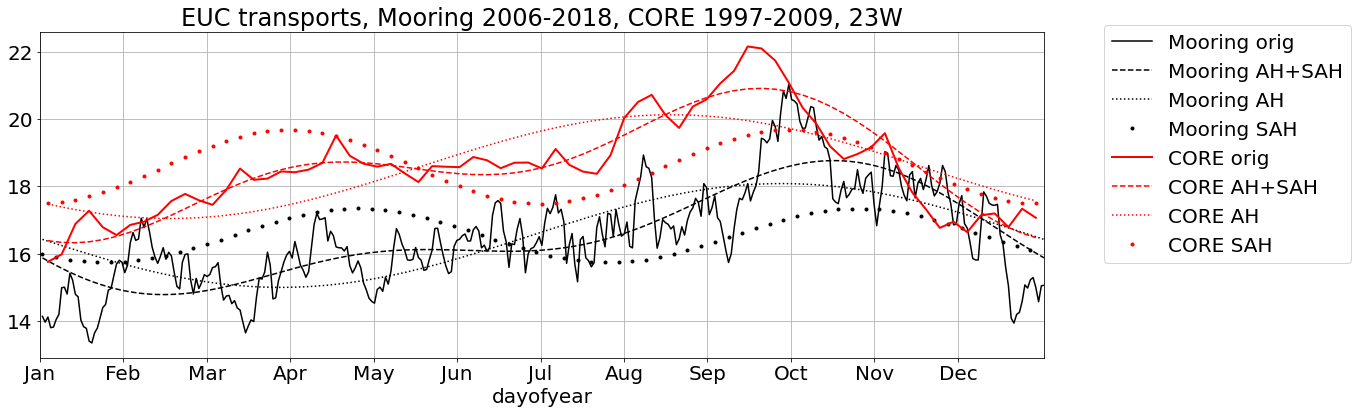

In [71]:
p=moor_cyc.plot.line('k',label='Mooring orig',size=6,aspect=3)
moor_AH_SAH_CYC.plot.line('--k',label='Mooring AH+SAH')
moor_AH_CYC.plot.line(':k',label='Mooring AH')
moor_SAH_CYC[0:-1:5].plot.line('.k',label='Mooring SAH')

CORE_cyc.T_30.sel(lon=-23,method='nearest').plot.line('r',label='CORE orig',linewidth=2)
CORE_AH_SAH_CYC.sel(lon=-23,method='nearest').plot.line('--r',label='CORE AH+SAH')
CORE_AH_CYC.sel(lon=-23,method='nearest').plot.line(':r',label='CORE AH')
CORE_SAH_CYC.sel(lon=-23,method='nearest').plot.line('.r',label='CORE SAH')

plt.title(('EUC transports, Mooring '+tlim_min+'-'+tlim_max+', CORE 1997-2009, 23W'))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, .85, 0.3, 0.2), loc='upper left')

plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))

if savefig:
    plt.savefig((out_dir_fig / f"INALT_CORE_obs_harmonics_cyc{tlim_min}_{tlim_max}{fig_format}"),dpi=300)